# Prediction Of Singapore HDB Prices

## Preparation

### Import libraries

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression,ElasticNetCV,\
RidgeCV,LassoCV,Ridge,Lasso,ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, \
cross_val_predict,GridSearchCV,cross_validate
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
import csv
warnings.filterwarnings('ignore')

### Read Csv into data frame

In [58]:
df = pd.read_csv("../data/train.csv")
df.head(2)

,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,88471,2016-05,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.0,Model A,2006,...,78,1,1.317659,103.882504,1138.633422,Geylang Methodist School,224,0,1.317659,103.882504
1,122598,2012-07,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987,...,45,1,1.349783,103.854529,447.894399,Kuo Chuan Presbyterian Secondary School,232,0,1.350110,103.854892


## Data cleaning and feature selection

### Check shape, nulls, zeroes and data type

In [59]:
def check_dataframe_shape_null_zeroes(df):
    print(f"Data frame shape: {df.shape}")
    print("\n")
    nulls = {k:v for k,v in dict(df.isnull().sum()).items() if v>0}
    for k,v in nulls.items():
        print(f"Empty rows in column [{k}]: {v}")
    print("\n")
    zeroes = {k:v for k,v in dict(df[df == 0].count()).items() if v>0}
    for k,v in zeroes.items():
        print(f"Rows with zeroes in column [{k}]: {v}")
    print("\n")

    column_types = {str(k):list(v) for k,v in df.groupby(df.dtypes,axis=1)}
    for k,v in column_types.items():
        print(f"Columns with data type [{k}]:{v}")
        print("\n")
check_dataframe_shape_null_zeroes(df)

Data frame shape: (150634, 77)


Empty rows in column [Mall_Nearest_Distance]: 829
Empty rows in column [Mall_Within_500m]: 92789
Empty rows in column [Mall_Within_1km]: 25426
Empty rows in column [Mall_Within_2km]: 1940
Empty rows in column [Hawker_Within_500m]: 97390
Empty rows in column [Hawker_Within_1km]: 60868
Empty rows in column [Hawker_Within_2km]: 29202


Rows with zeroes in column [1room_sold]: 150552
Rows with zeroes in column [2room_sold]: 144324
Rows with zeroes in column [3room_sold]: 95671
Rows with zeroes in column [4room_sold]: 30379
Rows with zeroes in column [5room_sold]: 62782
Rows with zeroes in column [exec_sold]: 124614
Rows with zeroes in column [multigen_sold]: 150557
Rows with zeroes in column [studio_apartment_sold]: 149226
Rows with zeroes in column [1room_rental]: 150332
Rows with zeroes in column [2room_rental]: 148770
Rows with zeroes in column [3room_rental]: 146805
Rows with zeroes in column [other_room_rental]: 150602
Rows with zeroes in column [Mall_

In [60]:
len(df['full_flat_type'].unique())

43

In [61]:
len(df['flat_model'].unique())

20

In [62]:
df.groupby("flat_type")['flat_model'].value_counts()

flat_type         flat_model            
1 ROOM            Improved                     82
2 ROOM            Model A                     739
                  Standard                    594
                  Improved                    521
                  Premium Apartment            37
                  2-room                        4
                  DBSS                          1
3 ROOM            New Generation            15227
                  Improved                  10240
                  Model A                    8454
                  Standard                   2522
                  Simplified                 1930
                  Premium Apartment           417
                  DBSS                        184
                  Terrace                      86
4 ROOM            Model A                   35127
                  New Generation             8139
                  Premium Apartment          7667
                  Simplified                 5309
         

In [63]:
df_stats = df.groupby("flat_type")[['floor_area_sqm','resale_price']].describe()
df_stats

floor_area_sqm                                              \
                          count        mean        std    min    25%    50%   
flat_type                                                                     
1 ROOM                     82.0   31.000000   0.000000   31.0   31.0   31.0   
2 ROOM                   1896.0   45.784810   3.400931   34.0   44.0   46.0   
3 ROOM                  39060.0   68.198569   6.551408   49.0   65.0   67.0   
4 ROOM                  61136.0   95.637639   7.601970   70.0   91.0   93.0   
5 ROOM                  36415.0  118.190636   7.414270   99.0  111.0  119.0   
EXECUTIVE               11989.0  144.151889  10.748670  124.0  140.0  145.0   
MULTI-GENERATION           56.0  161.250000  11.873959  132.0  159.0  164.0   

                               resale_price                                \
                    75%    max        count           mean            std   
flat_type                                                                   
1 ROOM             31.0   31.0         82.0  207015.463415   25312.327601   
2 ROOM             47.0   67.0       1896.0  245630.724156   35654.803782   
3 ROOM             73.0  280.0      39060.0  326837.412180   68184.115307   
4 ROOM            103.0  145.0      61136.0  445014.602849  109953.890470   
5 ROOM            122.0  160.0      36415.0  537147.679577  134933.680533   
EXECUTIVE         148.0  243.0      11989.0  633946.123062  108542.605834   
MULTI-GENERATION  166.0  179.0         56.0  767992.000000   77867.985088   

                                                                     
                       min       25%       50%       75%        max  
flat_type                                                            
1 ROOM            157000.0  185000.0  209000.0  230000.0   257000.0  
2 ROOM            150000.0  222000.0  245000.0  265000.0   510000.0  
3 ROOM            170000.0  284000.0  318000.0  355000.0  1185000.0  
4 ROOM            218000.0  373000.0  420000.0  480000.0  1186888.0  
5 ROOM            270000.0  445000.0  500000.0  590000.0  1258000.0  
EXECUTIVE         390000.0  560000.0  615000.0  690000.0  1210000.0  
MULTI-GENERATION  600000.0  719500.0  765500.0  815750.0   980000.0

Text(0, 0.5, 'Resale Price')

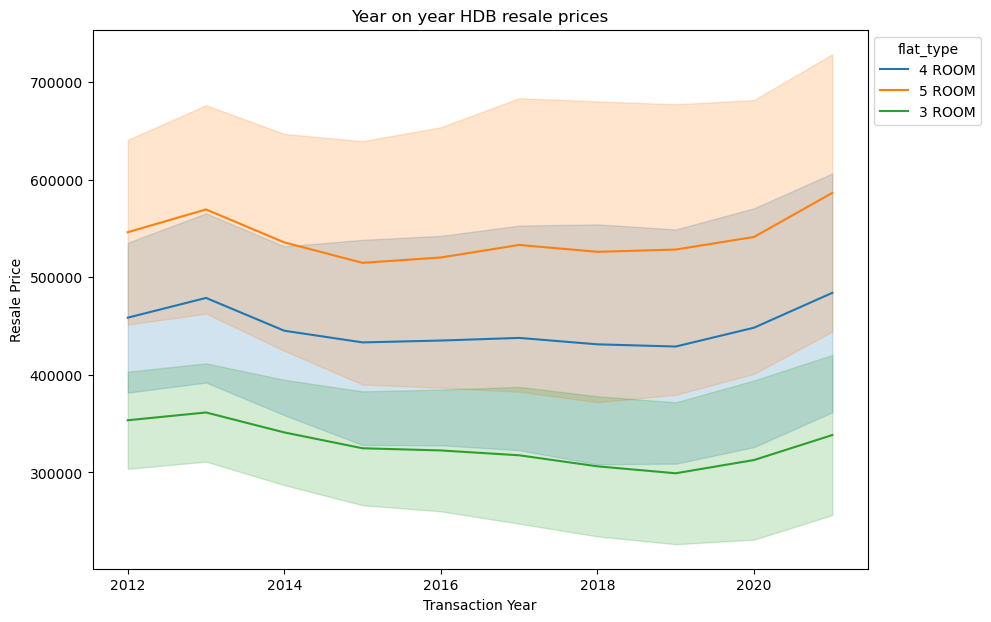

In [64]:
fig1 = plt.figure(figsize=(10,7))
df_yoy = df.loc[(df['flat_type']=='3 ROOM')|(df['flat_type']=='4 ROOM')|(df['flat_type']=='5 ROOM')][['flat_type','resale_price','Tranc_Year']]
fig1 = sns.lineplot(x='Tranc_Year', y='resale_price', hue='flat_type', errorbar='sd',err_style='band',
             data=df_yoy)
sns.move_legend(fig1, "upper left", bbox_to_anchor=(1, 1))
plt.title('Year on year HDB resale prices')
plt.xlabel('Transaction Year')
plt.ylabel('Resale Price')

### Feature Engineering

In [65]:
df['hdb_age_at_tranc'] = df['Tranc_Year']-df['lease_commence_date']

### Imputation of null values

In [66]:
col = ['Hawker_Within_2km','Mall_Within_2km', 'Mall_Nearest_Distance' ]
for i in col:
    mean = np.mean(df[i])
    df[i].fillna(value=mean, inplace=True)

## EDA

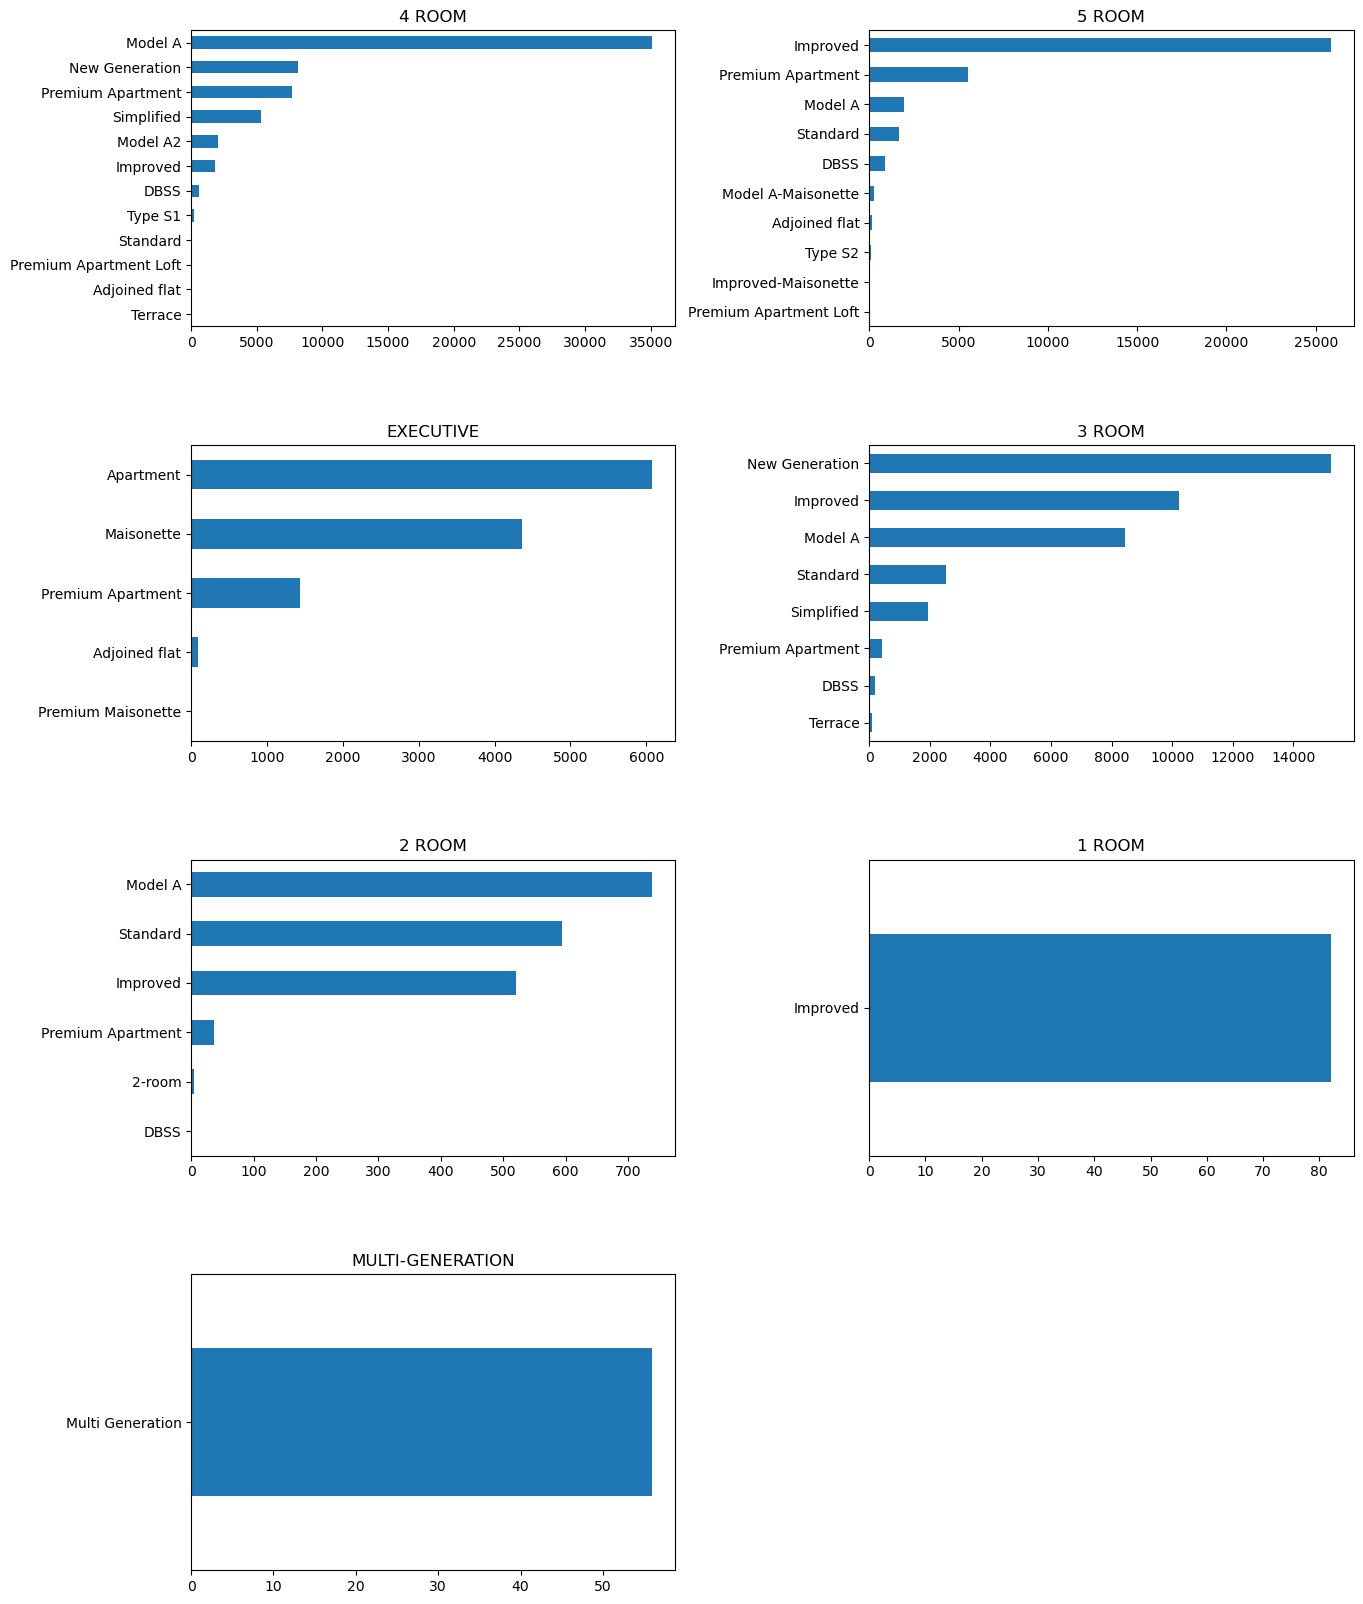

In [67]:
fig5 = plt.figure(figsize=(15,20))
fig5.subplots_adjust(hspace=0.4,wspace=0.4)
flat_model_by_flat_type = {}

for idx, d in enumerate(df['flat_type'].unique()):
    fig5.add_subplot(4,2,idx+1)
    df.loc[df['flat_type']==d]['flat_model'].value_counts().sort_values().plot(kind='barh')
    flat_model_by_flat_type[d] = df.loc[df['flat_type']==d]['flat_model'].unique()
    plt.title(d)

In [68]:
flat_model_by_flat_type

{'4 ROOM': array(['Model A', 'Simplified', 'Premium Apartment', 'Model A2',
        'New Generation', 'Improved', 'DBSS', 'Type S1',
        'Premium Apartment Loft', 'Terrace', 'Standard', 'Adjoined flat'],
       dtype=object),
 '5 ROOM': array(['Improved', 'Premium Apartment', 'Model A', 'Standard', 'DBSS',
        'Model A-Maisonette', 'Type S2', 'Adjoined flat',
        'Premium Apartment Loft', 'Improved-Maisonette'], dtype=object),
 'EXECUTIVE': array(['Apartment', 'Maisonette', 'Premium Apartment', 'Adjoined flat',
        'Premium Maisonette'], dtype=object),
 '3 ROOM': array(['Improved', 'New Generation', 'Model A', 'Standard', 'Simplified',
        'Premium Apartment', 'Terrace', 'DBSS'], dtype=object),
 '2 ROOM': array(['Standard', 'Improved', 'Model A', 'Premium Apartment', '2-room',
        'DBSS'], dtype=object),
 '1 ROOM': array(['Improved'], dtype=object),
 'MULTI-GENERATION': array(['Multi Generation'], dtype=object)}

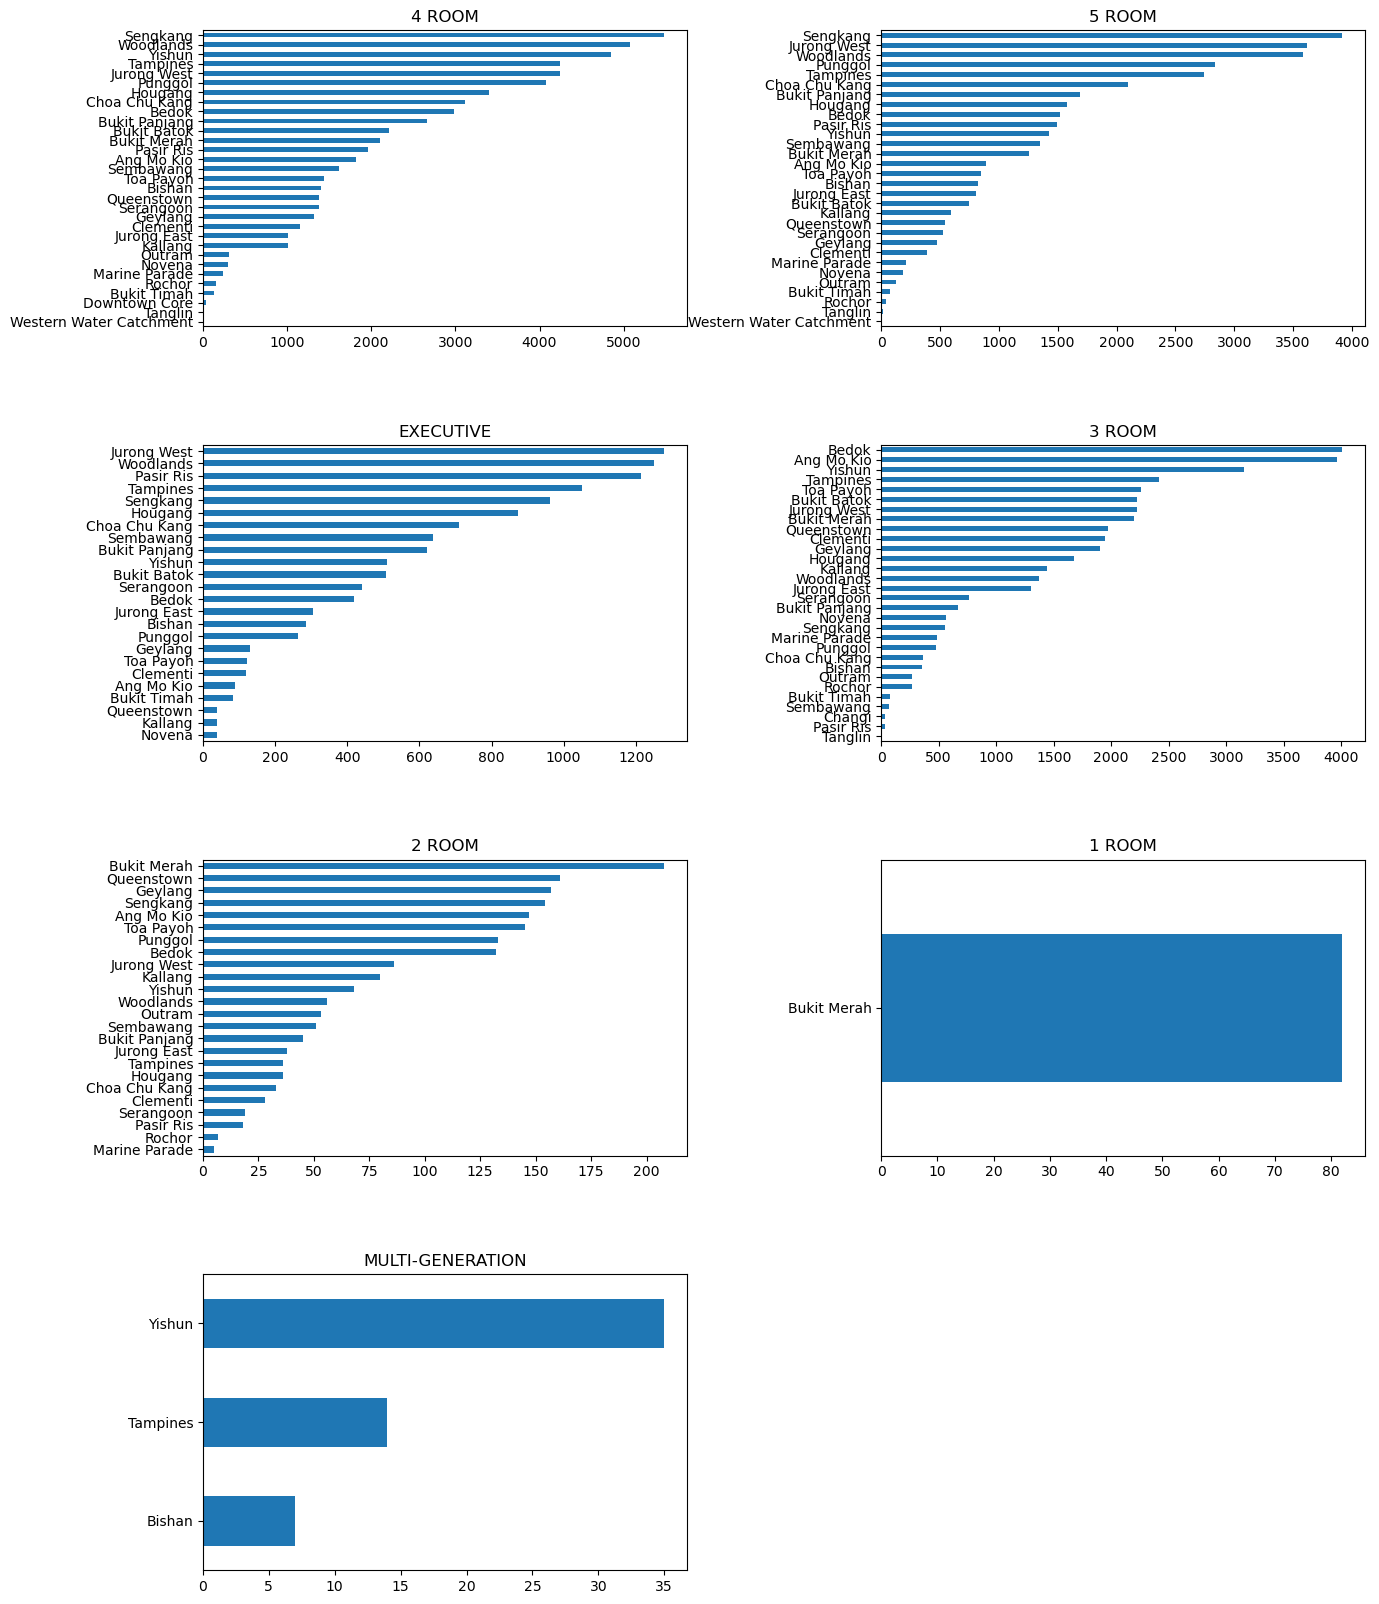

In [69]:
fig6 = plt.figure(figsize=(15,20))
fig6.subplots_adjust(hspace=0.4,wspace=0.4)
area_by_flat_type = {}

for idx, d in enumerate(df['flat_type'].unique()):
    fig6.add_subplot(4,2,idx+1)
    df.loc[df['flat_type']==d]['planning_area'].value_counts().sort_values().plot(kind='barh')
    area_by_flat_type[d]=df.loc[df['flat_type']==d]['planning_area'].unique()
    plt.title(d)

In [70]:
area_by_flat_type

{'4 ROOM': array(['Kallang', 'Bishan', 'Yishun', 'Sengkang', 'Bukit Merah',
        'Bukit Panjang', 'Woodlands', 'Bukit Batok', 'Jurong West',
        'Choa Chu Kang', 'Tampines', 'Toa Payoh', 'Geylang', 'Clementi',
        'Punggol', 'Jurong East', 'Bedok', 'Rochor', 'Hougang',
        'Ang Mo Kio', 'Bukit Timah', 'Serangoon', 'Sembawang', 'Pasir Ris',
        'Queenstown', 'Tanglin', 'Novena', 'Outram', 'Marine Parade',
        'Western Water Catchment', 'Downtown Core'], dtype=object),
 '5 ROOM': array(['Bishan', 'Hougang', 'Sengkang', 'Serangoon', 'Yishun',
        'Woodlands', 'Geylang', 'Jurong West', 'Sembawang', 'Novena',
        'Toa Payoh', 'Choa Chu Kang', 'Bukit Merah', 'Pasir Ris',
        'Punggol', 'Jurong East', 'Ang Mo Kio', 'Bukit Panjang', 'Bedok',
        'Tampines', 'Bukit Batok', 'Queenstown', 'Kallang', 'Clementi',
        'Marine Parade', 'Outram', 'Rochor', 'Bukit Timah', 'Tanglin',
        'Western Water Catchment'], dtype=object),
 'EXECUTIVE': array(['Bukit

### Manual splitting into categories and numerical features

In [71]:
df_1 = df.loc[df['flat_type']=='1 ROOM']
df_2 = df.loc[df['flat_type']=='2 ROOM']
df_mid = df.loc[(df['flat_type']=='3 ROOM') | (df['flat_type']=='4 ROOM')]
df_5 = df.loc[df['flat_type']=='5 ROOM']
df_high = df.loc[(df['flat_type']=='EXECUTIVE')| (df['flat_type']=='MULTI-GENERATION')]

In [93]:
num_1 = ['floor_area_sqm',
 'hdb_age_at_tranc',
 'Hawker_Nearest_Distance',
 'mrt_nearest_distance']

num_2 = ['floor_area_sqm',
 'mid',
 'max_floor_lvl',
 'hdb_age_at_tranc',
 'Mall_Nearest_Distance',
 'Hawker_Nearest_Distance',
 'mrt_nearest_distance']

num_mid = ['floor_area_sqm',
 'mid',
 'max_floor_lvl',
 'hdb_age_at_tranc',
 'Mall_Nearest_Distance',
 'Hawker_Nearest_Distance',
 'mrt_nearest_distance',
 'cutoff_point']

num_5 = ['floor_area_sqm',
 'mid',
 'max_floor_lvl',
 'hdb_age_at_tranc',
 'Mall_Nearest_Distance',
 'Hawker_Nearest_Distance',
 'mrt_nearest_distance',
 'cutoff_point']

num_high = ['floor_area_sqm',
 'hdb_age_at_tranc',
 'mrt_nearest_distance']

cat_1 = ['Tranc_Year']

cat_2 = ['Tranc_Year',
'flat_model',
'planning_area']

cat_mid = ['Tranc_Year',
'flat_type',
'flat_model',
'bus_interchange',
'mrt_interchange',
'planning_area']

cat_5 = ['Tranc_Year',
'flat_model',
'bus_interchange',
'mrt_interchange',
'planning_area']

cat_high = ['Tranc_Year',
'flat_type',
'planning_area']

### Correlation heat map of numerical columns

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0.5, 0, 'floor_area_sqm'),
  Text(1.5, 0, 'mid'),
  Text(2.5, 0, 'max_floor_lvl'),
  Text(3.5, 0, 'hdb_age_at_tranc'),
  Text(4.5, 0, 'Mall_Nearest_Distance'),
  Text(5.5, 0, 'Hawker_Nearest_Distance'),
  Text(6.5, 0, 'mrt_nearest_distance'),
  Text(7.5, 0, 'cutoff_point'),
  Text(8.5, 0, 'resale_price')])

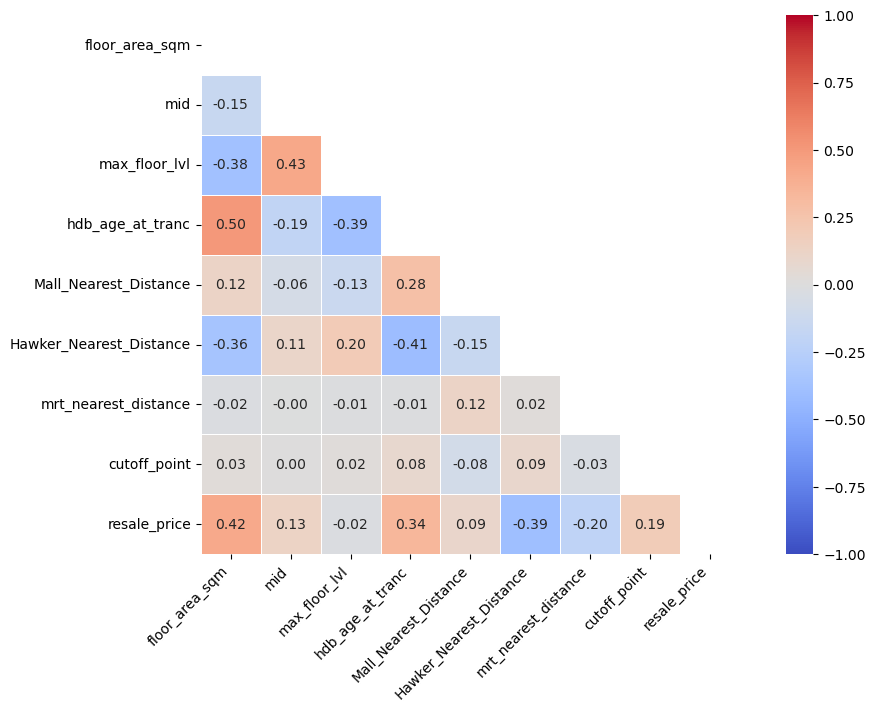

In [73]:
corr = df_high[num_mid+['resale_price']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (12,7))
sns.heatmap(corr, mask = mask, square = True, annot = True, vmin = -1, vmax = 1, linewidths = .5, cmap = "coolwarm",fmt='.2f')
plt.xticks(rotation=45, ha='right') 

### Bar charts for categorical features

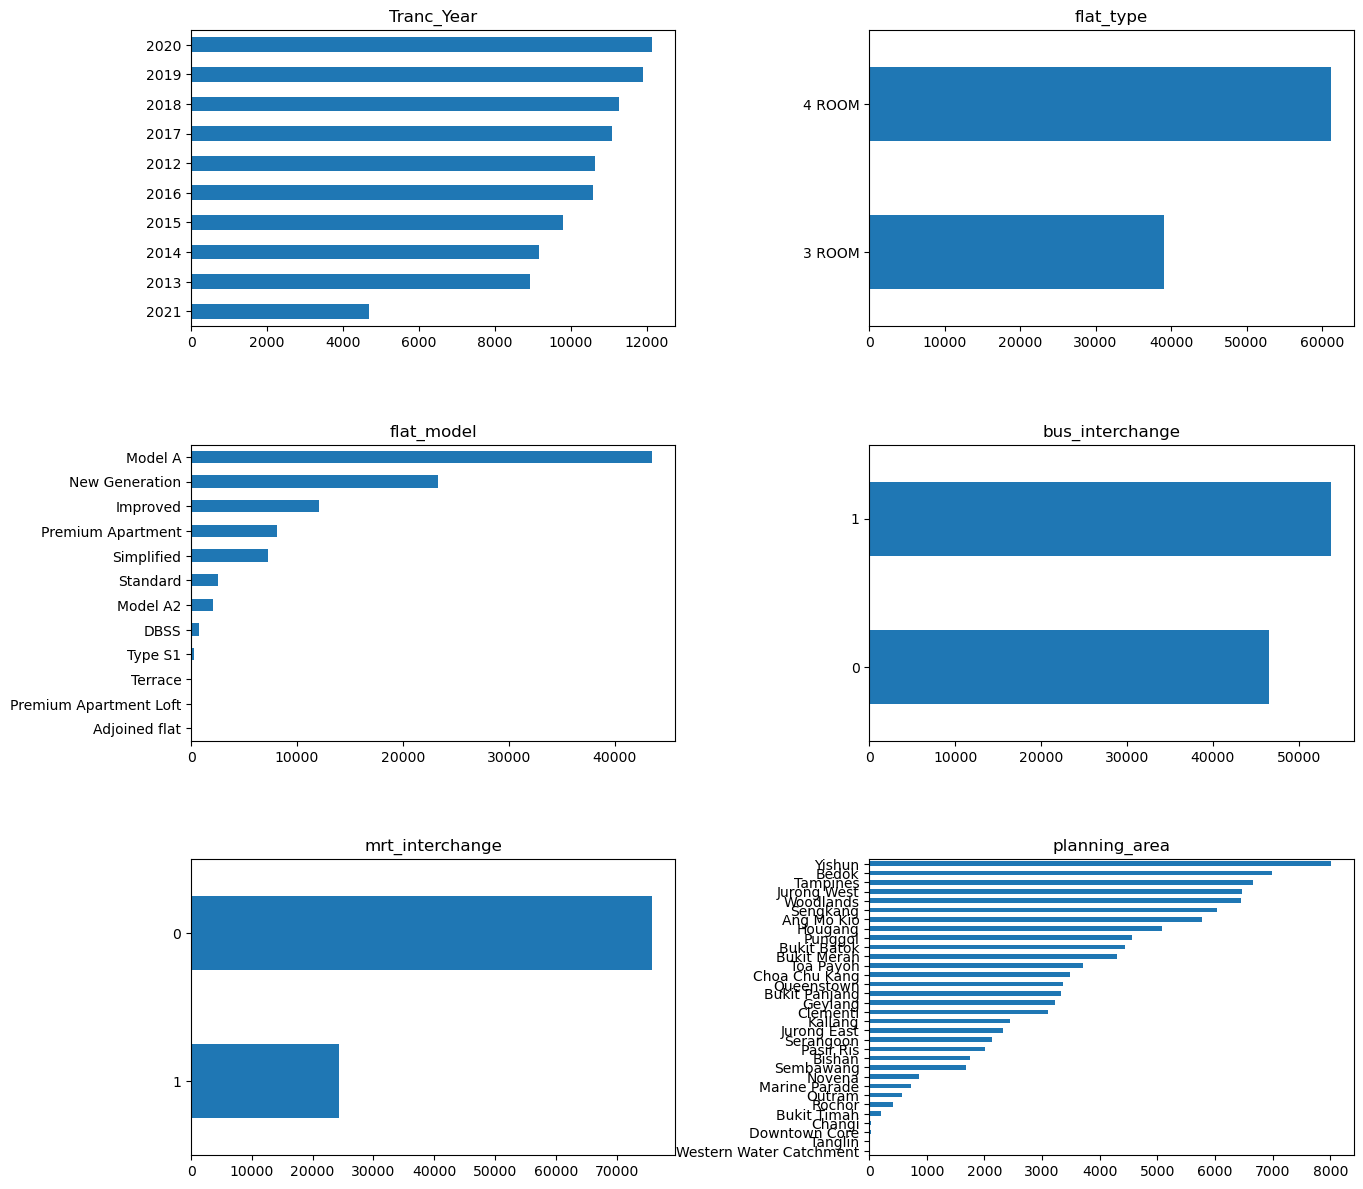

In [74]:
fig1 = plt.figure(figsize=(15,20))
fig1.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(cat_mid):
    fig1.add_subplot(4,2,idx+1)
    df_mid[d].value_counts().sort_values().plot(kind='barh')
    plt.title(d)

### Histogram for numerical features

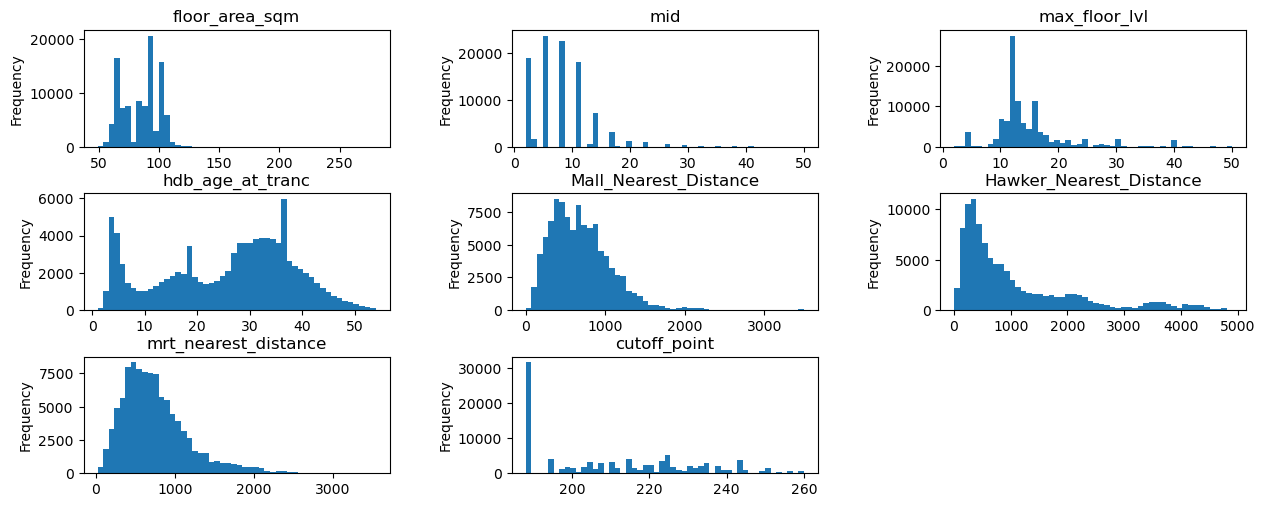

In [75]:
fig1b = plt.figure(figsize=(15,10))
fig1b.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(num_mid):
    fig1b.add_subplot(5,3,idx+1)
    df_mid[d].plot(kind='hist',bins=50,title=d)

## Feature Engineering and Selection

### Setup features and target. 
#### Use logarithm value of predicted value

In [76]:
X_1= df_1[num_1+cat_1]
y_1= df_1['resale_price']
X_2= df_2[num_2+cat_2]
y_2= df_2['resale_price']
X_mid= df_mid[num_mid+cat_mid]
y_mid= df_mid['resale_price']
X_5= df_5[num_5+cat_5]
y_5= df_5['resale_price']
X_high= df_high[num_high+cat_high]
y_high= df_high['resale_price']

### Train and Test Split

In [94]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1,y_1,test_size = 0.2,random_state = 42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2,y_2,test_size = 0.2,random_state = 42)
X_train_mid, X_test_mid, y_train_mid, y_test_mid = train_test_split(X_mid,y_mid,test_size = 0.2,random_state = 42)
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5,y_5,test_size = 0.2,random_state = 42)
X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(X_high,y_high,test_size = 0.2,random_state = 42)

## Model Building

In [95]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

In [96]:
model = Ridge()
hyperparameters = {'ridge__alpha': [0.01, 0.1,1,10]}
preprocessor_1 = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, cat_1),
    ('standard_scaler', numerical_preprocessor, num_1)])
preprocessor_2 = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, cat_2),
    ('standard_scaler', numerical_preprocessor, num_2)])
preprocessor_mid = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, cat_mid),
    ('standard_scaler', numerical_preprocessor, num_mid)])
preprocessor_5 = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, cat_5),
    ('standard_scaler', numerical_preprocessor, num_5)])
preprocessor_high = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, cat_high),
    ('standard_scaler', numerical_preprocessor, num_high)])

pipe_1 = make_pipeline(preprocessor_1, model)
gs_1 = GridSearchCV(pipe_1, hyperparameters,cv=5,scoring='neg_root_mean_squared_error')

pipe_2 = make_pipeline(preprocessor_2, model)
gs_2 = GridSearchCV(pipe_2, hyperparameters,cv=5,scoring='neg_root_mean_squared_error')

pipe_mid = make_pipeline(preprocessor_mid, model)
gs_mid = GridSearchCV(pipe_mid, hyperparameters,cv=5,scoring='neg_root_mean_squared_error')

pipe_5 = make_pipeline(preprocessor_5, model)
gs_5 = GridSearchCV(pipe_5, hyperparameters,cv=5,scoring='neg_root_mean_squared_error')

pipe_high = make_pipeline(preprocessor_high, model)
gs_high = GridSearchCV(pipe_high, hyperparameters,cv=5,scoring='neg_root_mean_squared_error')

In [97]:
%%time
gs_1.fit(X_train_1,y_train_1)
print(f"Best Score for 1 ROOM: {-gs_1.best_score_}")
print(f"Best Params for 1 ROOM: {gs_1.best_params_}")

gs_2.fit(X_train_2,y_train_2)
print(f"Best Score for 2 ROOM: {-gs_2.best_score_}")
print(f"Best Params for 2 ROOM: {gs_2.best_params_}")

gs_mid.fit(X_train_mid,y_train_mid)
print(f"Best Score for 3,4 ROOM: {-gs_mid.best_score_}")
print(f"Best Params for 3,4 ROOM: {gs_mid.best_params_}")

gs_5.fit(X_train_5,y_train_5)
print(f"Best Score for 5 ROOM: {-gs_5.best_score_}")
print(f"Best Params for 5 ROOM: {gs_5.best_params_}")

gs_high.fit(X_train_high,y_train_high)
print(f"Best Score for Executive: {-gs_high.best_score_}")
print(f"Best Params for Executive: {gs_high.best_params_}")

Best Score for 1 ROOM: 16098.947935231437
Best Params for 1 ROOM: {'ridge__alpha': 10}
Best Score for 2 ROOM: 19540.260580561568
Best Params for 2 ROOM: {'ridge__alpha': 0.1}
Best Score for 3,4 ROOM: 40341.29267580542
Best Params for 3,4 ROOM: {'ridge__alpha': 0.01}
Best Score for 5 ROOM: 47411.51330775597
Best Params for 5 ROOM: {'ridge__alpha': 0.01}
Best Score for Executive: 54219.91137254362
Best Params for Executive: {'ridge__alpha': 0.01}
CPU times: total: 49.8 s
Wall time: 17.7 s


## Model Evaluation

In [117]:
predicted = gs_5.best_estimator_.predict(X_test_5)
mse = metrics.mean_squared_error(y_test_5, predicted)
print(f"Test score for 5 room = {np.sqrt(mse):.3f}")

predicted = gs_mid.best_estimator_.predict(X_test_mid)
mse = metrics.mean_squared_error(y_test_mid, predicted)
print(f"Test score for 3,4 room = {np.sqrt(mse):.3f}")

predicted = gs_2.best_estimator_.predict(X_test_2)
mse = metrics.mean_squared_error(y_test_2, predicted)
print(f"Test score for 2 room = {np.sqrt(mse):.3f}")

predicted = gs_1.best_estimator_.predict(X_test_1)
mse = metrics.mean_squared_error(y_test_1, predicted)
print(f"Test score for 1 room = {np.sqrt(mse):.3f}")

predicted = gs_high.best_estimator_.predict(X_test_high)
mse = metrics.mean_squared_error(y_test_high, predicted)
print(f"Test score for executive room = {np.sqrt(mse):.3f}")


Test score for 5 room = 46489.914
Test score for 3,4 room = 40658.811
Test score for 2 room = 17614.438
Test score for 1 room = 11510.341
Test score for executive room = 54033.549


In [86]:
def get_coeffs_from_gs(gs):
    coefficients = gs.best_estimator_[1].coef_
    out_columns_numerical = gs.best_estimator_[0].transformers_[1][2]
    out_columns_category = list(gs.best_estimator_[0].transformers_[0][1].get_feature_names())
    out_columns = out_columns_category+out_columns_numerical
    gs_coef = sorted(list(zip(np.round(coefficients,3),out_columns)),key=lambda x: x[0],reverse=True)
    return gs_coef

In [163]:
coefs = get_coeffs_from_gs(gs_mid)
print("Transaction Year")
print(*[x for x in coefs if "x0" in x[1]],sep='\n')
print("Flat Type")
print(*[x for x in coefs if "x1" in x[1]],sep='\n')
print("Flat Model")
print(*[x for x in coefs if "x2" in x[1]],sep='\n')
print("Bus Interchange")
print(*[x for x in coefs if "x3" in x[1]],sep='\n')
print("MRT Interchange")
print(*[x for x in coefs if "x4" in x[1]],sep='\n')
print("Planning Area")
print(*[x for x in coefs if "x5" in x[1]],sep='\n')
print("Numerical Features")
print(*[x for x in coefs if not x[1].startswith('x')],sep='\n')

Transaction Year
(32127.346, 'x0_2013')
(19623.142, 'x0_2021')
(17599.765, 'x0_2012')
(6081.793, 'x0_2014')
(-7243.99, 'x0_2020')
(-9029.609, 'x0_2015')
(-9399.767, 'x0_2016')
(-12398.42, 'x0_2017')
(-18046.239, 'x0_2018')
(-19314.022, 'x0_2019')
Flat Type
(15290.76, 'x1_4 ROOM')
(-15290.76, 'x1_3 ROOM')
Flat Model
(391745.703, 'x2_Terrace')
(63722.839, 'x2_Premium Apartment Loft')
(38124.245, 'x2_Type S1')
(27730.778, 'x2_DBSS')
(22894.103, 'x2_Adjoined flat')
(-65789.048, 'x2_Premium Apartment')
(-66788.329, 'x2_New Generation')
(-71064.156, 'x2_Simplified')
(-76012.976, 'x2_Model A')
(-86064.293, 'x2_Standard')
(-88238.293, 'x2_Improved')
(-90260.573, 'x2_Model A2')
Bus Interchange
(2882.5, 'x3_1')
(-2882.5, 'x3_0')
MRT Interchange
(1452.693, 'x4_1')
(-1452.693, 'x4_0')
Planning Area
(167581.655, 'x5_Marine Parade')
(129765.361, 'x5_Changi')
(128802.822, 'x5_Bukit Timah')
(102803.487, 'x5_Downtown Core')
(91874.415, 'x5_Outram')
(74693.398, 'x5_Bukit Merah')
(68420.77, 'x5_Queenstow

In [164]:
coefs = get_coeffs_from_gs(gs_5)
print("Transaction Year")
print(*[x for x in coefs if "x0" in x[1]],sep='\n')
print("Flat Model")
print(*[x for x in coefs if "x1" in x[1]],sep='\n')
print("Bus Interchange")
print(*[x for x in coefs if "x2" in x[1]],sep='\n')
print("MRT Interchange")
print(*[x for x in coefs if "x3" in x[1]],sep='\n')
print("Planning Area")
print(*[x for x in coefs if "x4" in x[1]],sep='\n')
print("Numerical Features")
print(*[x for x in coefs if not x[1].startswith('x')],sep='\n')

Transaction Year
(45384.04, 'x0_2021')
(23893.291, 'x0_2013')
(10549.184, 'x0_2020')
(5410.568, 'x0_2012')
(-6160.696, 'x0_2019')
(-8951.745, 'x0_2014')
(-14794.305, 'x0_2018')
(-16124.649, 'x0_2016')
(-17908.324, 'x0_2017')
(-21297.363, 'x0_2015')
Flat Model
(156506.537, 'x1_Improved-Maisonette')
(54322.109, 'x1_Premium Apartment Loft')
(52532.913, 'x1_Type S2')
(32834.401, 'x1_Model A-Maisonette')
(19957.698, 'x1_DBSS')
(-34809.753, 'x1_Adjoined flat')
(-52126.502, 'x1_Standard')
(-70519.51, 'x1_Premium Apartment')
(-77697.58, 'x1_Improved')
(-81000.313, 'x1_Model A')
Bus Interchange
(4190.019, 'x2_1')
(-4190.019, 'x2_0')
MRT Interchange
(4624.893, 'x3_1')
(-4624.893, 'x3_0')
Planning Area
(303234.029, 'x4_Marine Parade')
(274999.967, 'x4_Tanglin')
(195645.368, 'x4_Bukit Timah')
(151896.981, 'x4_Queenstown')
(128405.764, 'x4_Bishan')
(121887.77, 'x4_Bukit Merah')
(93192.511, 'x4_Outram')
(84875.1, 'x4_Clementi')
(61874.979, 'x4_Geylang')
(60927.48, 'x4_Toa Payoh')
(60062.331, 'x4_Kal

## Prediction

In [137]:
test_df = pd.read_csv("../data/test.csv")
test_df.head(3)

,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,114982,2012-11,YISHUN,4 ROOM,173,YISHUN AVE 7,07 TO 09,84.0,Simplified,1987,...,92,0,1.433681,103.832924,156.322353,Ahmad Ibrahim Secondary School,218,0,1.436235,103.829987
1,95653,2019-08,JURONG WEST,5 ROOM,986C,JURONG WEST ST 93,04 TO 06,112.0,Premium Apartment,2008,...,45,0,1.339244,103.698896,739.371688,Jurong West Secondary School,199,0,1.335256,103.702098
2,40303,2013-10,ANG MO KIO,3 ROOM,534,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,...,36,0,1.371893,103.851811,305.071191,Anderson Secondary School,245,0,1.374242,103.851430


In [138]:
check_dataframe_shape_null_zeroes(test_df)

Data frame shape: (16737, 76)


Empty rows in column [Mall_Nearest_Distance]: 84
Empty rows in column [Mall_Within_500m]: 10292
Empty rows in column [Mall_Within_1km]: 2786
Empty rows in column [Mall_Within_2km]: 213
Empty rows in column [Hawker_Within_500m]: 10755
Empty rows in column [Hawker_Within_1km]: 6729
Empty rows in column [Hawker_Within_2km]: 3254


Rows with zeroes in column [1room_sold]: 16730
Rows with zeroes in column [2room_sold]: 16027
Rows with zeroes in column [3room_sold]: 10607
Rows with zeroes in column [4room_sold]: 3297
Rows with zeroes in column [5room_sold]: 7002
Rows with zeroes in column [exec_sold]: 13916
Rows with zeroes in column [multigen_sold]: 16727
Rows with zeroes in column [studio_apartment_sold]: 16592
Rows with zeroes in column [1room_rental]: 16711
Rows with zeroes in column [2room_rental]: 16516
Rows with zeroes in column [3room_rental]: 16319
Rows with zeroes in column [other_room_rental]: 16736
Rows with zeroes in column [Mall_Nearest_Distance]

In [139]:
test_df['hdb_age_at_tranc'] = test_df['Tranc_Year']-test_df['lease_commence_date']

In [140]:
col = ['Hawker_Within_2km','Mall_Within_2km', 'Mall_Nearest_Distance' ]
for i in col:
    mean = np.mean(test_df[i])
    test_df[i].fillna(value=mean, inplace=True)

In [141]:
test_1 = test_df.loc[df['flat_type']=='1 ROOM']
test_2 = test_df.loc[df['flat_type']=='2 ROOM']
test_mid = test_df.loc[(df['flat_type']=='3 ROOM') | (df['flat_type']=='4 ROOM')]
test_5 = test_df.loc[df['flat_type']=='5 ROOM']
test_high = test_df.loc[(df['flat_type']=='EXECUTIVE')| (df['flat_type']=='MULTI-GENERATION')]

In [142]:
pred_1 = gs_1.best_estimator_.predict(test_1[num_1+cat_1])
pred_2 = gs_2.best_estimator_.predict(test_2[num_2+cat_2])
pred_mid = gs_mid.best_estimator_.predict(test_mid[num_mid+cat_mid])
pred_5 = gs_5.best_estimator_.predict(test_5[num_5+cat_5])
pred_high = gs_high.best_estimator_.predict(test_high[num_high+cat_high])

In [159]:
len(np.concatenate((pred_1, pred_2,pred_mid,pred_5,pred_high), axis=0))

16737

In [160]:
sub_df = pd.DataFrame()
sub_df["Id"] = test_1['id'].append(test_2['id']).append(test_mid['id']).append(test_5['id']).append(test_high['id'])
sub_df["Predicted"] = np.concatenate((pred_1, pred_2,pred_mid,pred_5,pred_high), axis=0)
sub_df.to_csv("../data/sub_reg_multi.csv", index=False)

In [161]:
sub_df.head()

,Id,Predicted
1202,122938,353274.755542
2029,140162,358665.135794
6257,152501,285389.653392
6398,7915,204740.312608
7367,175261,356308.899434


In [162]:
sub_df.shape

(16737, 2)